### 기본 패키지 가져오기

In [1]:
import torch
import random
import numpy as np
import os
import datetime

### wandb 로그인

In [2]:
# 먼저 콘솔창에서 wandb설치
# pip install wandb 

# 그 다음 다음 이 주피터 노트북에서 다음 코드를 실행. 
# wandb.login()
# https://wandb.ai/authorize 여기 로그인하고 API 키 기입

import wandb

# https://wandb.ai/signup # 여기서 runnig 과정 및 결과 확인 가능

### 내 커스텀 패키지 가져오기

In [3]:
import modules

seed 설정

In [4]:
def seed_assign(seed):
    random.seed(seed)                          # Python random 시드 고정
    np.random.seed(seed)                       # NumPy 시드 고정
    torch.manual_seed(seed)                    # PyTorch CPU 시드 고정
    torch.cuda.manual_seed(seed)               # PyTorch GPU 시드 고정
    torch.cuda.manual_seed_all(seed)           # PyTorch 멀티 GPU 시드 고정
    torch.backends.cudnn.deterministic = True  # 연산의 결정론적 동작 보장
    # torch.backends.cudnn.benchmark = False     # 성능 최적화 비활성화 (결정론적 보장)


snn network 만들기

In [5]:
class SNN(torch.nn.Module):
    def __init__(self, v_decay, v_threshold, v_reset_mode, sg_width, surrogate, CLASS_NUM, in_channels, IMAGE_SIZE, time_step):
        super(SNN, self).__init__()
        self.TIME = time_step

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        IMAGE_SIZE = (IMAGE_SIZE + 2 - 3 // 1) + 1

        self.lif1 = modules.neuron.LIF_layer(v_decay, v_threshold, v_reset_mode, sg_width, surrogate)

        self.fc1 = torch.nn.Linear(32 * IMAGE_SIZE * IMAGE_SIZE, CLASS_NUM)

        self.lif2 = modules.neuron.LIF_layer(v_decay, v_threshold, v_reset_mode, sg_width, surrogate)

    def forward(self, x):
        # SHAPE : [Batch, Time_step, Channel, H, W]

        x = torch.transpose(x, 0, 1)
        # SHAPE : [Time_step, Batch, Channel, H, W]

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, *spatial_dims)
        # SHAPE : [Time_step * Batch, Channel, H, W]

        x = self.conv1(x)
        # SHAPE : [Time_step * Batch, Channel, H, W]

        TB, *spatial_dims = x.shape
        x = x.reshape(self.TIME , TB // self.TIME, *spatial_dims)
        # SHAPE : [Time_step, Batch, Channel, H, W]

        x = self.lif1(x)
        # SHAPE : [Time_step, Batch, Channel, H, W]
        
        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, *spatial_dims)
        # SHAPE : [Time_step * Batch, Channel, H, W]

        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        # SHAPE : [Time_step * Batch, CLASS_NUM]

        TB, *spatial_dims = x.shape
        x = x.reshape(self.TIME , TB // self.TIME, *spatial_dims)
        # SHAPE : [Time_step, Batch, CLASS_NUM]

        x = self.lif2(x)
        # SHAPE : [Time_step, Batch, CLASS_NUM]

        x = x.sum(dim=0)
        # SHAPE : [Batch, CLASS_NUM]

        return x

main 함수

In [6]:
def snn_system(seed,
                which_data,
                batch_size,
                data_path,
                learning_rate,
                time_step,
                v_decay,
                v_threshold,
                v_reset_mode,
                sg_width,
                surrogate,
                max_epoch,
                gpu,
                current_time):
    seed_assign(seed)
    hyperparameters = locals()
    print('hyperparameters', hyperparameters)
    
    wandb.config.update(hyperparameters) # wandb에 모든 하이퍼파라미터 업로드
    wandb.run.name = f'{current_time}' # wandb run name 설정

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, CLASS_NUM, in_channels, IMAGE_SIZE = modules.data_loader.data_loader(which_data, data_path, batch_size)
    net = SNN(v_decay=v_decay, v_threshold=v_threshold, v_reset_mode=v_reset_mode, sg_width=sg_width, surrogate=surrogate, CLASS_NUM=CLASS_NUM, in_channels=in_channels, IMAGE_SIZE=IMAGE_SIZE, time_step=time_step)
    net = net.to(device)

    wandb.watch(net, log="all", log_freq = 10) # 모델을 wandb에 로깅

    criterion = torch.nn.CrossEntropyLoss().to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    best_validation_accuracy = 0.0
    for epoch in range(max_epoch):
        print(f'Epoch-{epoch}')
        net.train()
        correct_train = 0
        total_train = 0
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1).repeat(1, time_step, 1, 1, 1)  # repeat 코딩. rate코딩 등을 실험해봐도 좋다. # (batch, time_step, C, H, W)
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_loss += loss.item()

        training_accuracy = 100 * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)
        print(f'Training_loss: {avg_train_loss:.4f}, Training_accuracy: {training_accuracy:.2f} %')

        # Validation
        net.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                images = images.unsqueeze(1).repeat(1, time_step, 1, 1, 1)  # repeat 코딩. rate코딩 등 실험해봐도 좋다. # (batch, time_step, C, H, W)

                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        avg_val_loss = val_loss / len(test_loader)
        best_validation_accuracy = max(best_validation_accuracy, validation_accuracy)
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f} %, Best Validation Accuracy: {best_validation_accuracy:.2f} %')
        print()
        wandb.log({"avg_train_loss": avg_train_loss})
        wandb.log({"training_accuracy": training_accuracy})
        wandb.log({"avg_val_loss": avg_val_loss})
        wandb.log({"validation_accuracy": validation_accuracy})
        wandb.log({"best_validation_accuracy": best_validation_accuracy})



sweep 파라미터 지정

In [7]:
sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
sweep_configuration = {
    'method': 'bayes', # 'random', 'bayes', 'grid'  # sweep 전량. 관련 정보 구글링 권장
    'name': f'sweep_{sweep_start_time}', # sweep name 지정
    'metric': {'goal': 'maximize', 'name': 'best_validation_accuracy'}, # main 함수 (여기서는 snn_system)에서 목표로 하는 변수 지정
    'parameters': 
    {
        # sweep 하고 싶은 하이퍼 파라미터 지정하면 됨. 단, 정수 실수는 하나만 담아야됨. ex) [3,2,1.0] 안됨. [3,2,1] 가능. [3.0,2.0,1.2] 가능.
        "seed": {"values": [42]}, 
        "which_data": {"values": ['MNIST']}, 
        "batch_size": {"values": [32,64,96]}, # 배치사이즈 스윕하고 싶을 때  
        "data_path": {"values": ['/data2']}, 
        "learning_rate": {"values": [0.001]}, 
        # "learning_rate": {"max": 0.1, "min": 0.0001}, 이렇게 continuous값으로 sweep도 가능함. 하지만 sweep method에서 'grid'는 사용 불가.
        "time_step": {"values": [10]}, 
        "v_decay": {"values": [0.5]}, 
        "v_threshold": {"values": [0.5]}, 
        "v_reset_mode": {"values": ['soft_reset']}, 
        "sg_width": {"values": [4.0]}, 
        "surrogate": {"values": ['sigmoid']}, 
        "max_epoch": {"values": [10]}, 
        # "gpu": {"values": []},  # 이건 밑에서 직접 지정
        # "current_time": {"values": []}, # 이건 밑에서 직접 지정
     }
}


def wandb_run():
    ### my_snn control board ########################
    wandb.init(save_code = False)
    seed = wandb.config.seed
    which_data = wandb.config.which_data
    batch_size = wandb.config.batch_size
    data_path = wandb.config.data_path
    learning_rate = wandb.config.learning_rate
    time_step = wandb.config.time_step
    v_decay = wandb.config.v_decay
    v_threshold = wandb.config.v_threshold
    v_reset_mode = wandb.config.v_reset_mode
    sg_width = wandb.config.sg_width
    surrogate = wandb.config.surrogate
    max_epoch = wandb.config.max_epoch
    gpu = '0' # 사용할 GPU 번호
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}" # 그냥 현재 시각 (마이크로초까지)

    snn_system( 
            seed = seed,
            which_data = which_data,
            batch_size = batch_size,
            data_path = data_path,
            learning_rate = learning_rate,
            time_step = time_step,
            v_decay = v_decay,
            v_threshold = v_threshold,
            v_reset_mode = v_reset_mode,
            sg_width = sg_width,
            surrogate = surrogate,
            max_epoch = max_epoch,
            gpu = gpu,
            current_time = current_time,
        )
    
# sweep_id = 'ygoj9jt4' # 현재 다른 주피터 노트북에서 돌아가고 있는 sweep을 병렬적으로 여러개 돌리려면 여기 sweep_id기입 후 아랫 줄 주석처리
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'wandb_tutorial') # 프로젝트 name 지정
wandb.agent(sweep_id, function=wandb_run, count=100000) #count - 몇번 run할지 횟수 결정
# 보통 sweep metric을 'bayes'로 두고 count는 100000같이 많이 둔다. 대충 많이 돌아간 것 같으면 끄면 되기 때문.
# 또는 sweep metric을 'grid'로 돌리면 지정한 count와는 상관없이 모든 하이퍼파라미터 조합을 다 돌리고 sweep을 종료한다. 이 경우 sweep parameter에서 'min', 'max'로 지정은 하면 안됨.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: hg9o5ksl
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/wandb_tutorial/sweeps/hg9o5ksl


wandb: Agent Starting Run: 1n2wiror with config:
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 10
wandb: 	seed: 42
wandb: 	sg_width: 4
wandb: 	surrogate: sigmoid
wandb: 	time_step: 10
wandb: 	v_decay: 0.5
wandb: 	v_reset_mode: soft_reset
wandb: 	v_threshold: 0.5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'time_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_reset_mode' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).


hyperparameters {'seed': 42, 'which_data': 'MNIST', 'batch_size': 64, 'data_path': '/data2', 'learning_rate': 0.001, 'time_step': 10, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset_mode': 'soft_reset', 'sg_width': 4, 'surrogate': 'sigmoid', 'max_epoch': 10, 'gpu': '0', 'current_time': '20250317_123808_218'}
Epoch-0
Training_loss: 4.3529, Training_accuracy: 22.15 %
Validation Loss: 4.0000, Validation Accuracy: 29.93 %, Best Validation Accuracy: 29.93 %

Epoch-1
Training_loss: 1.6688, Training_accuracy: 60.65 %
Validation Loss: 0.6147, Validation Accuracy: 77.26 %, Best Validation Accuracy: 77.26 %

Epoch-2
Training_loss: 0.4994, Training_accuracy: 81.33 %
Validation Loss: 0.3437, Validation Accuracy: 87.37 %, Best Validation Accuracy: 87.37 %

Epoch-3
Training_loss: 0.3274, Training_accuracy: 87.73 %
Validation Loss: 0.3358, Validation Accuracy: 87.55 %, Best Validation Accuracy: 87.55 %

Epoch-4
Training_loss: 0.2991, Training_accuracy: 88.39 %
Validation Loss: 0.3212, Validation Accurac

avg_train_loss,█▃▁▁▁▁▁▁▁▁
avg_val_loss,█▂▁▁▁▁▁▁▁▁
best_validation_accuracy,▁▇████████
training_accuracy,▁▅▇███████
validation_accuracy,▁▇████████
avg_train_loss,0.26474
avg_val_loss,0.32506
best_validation_accuracy,87.88
training_accuracy,89.23667
validation_accuracy,87.66


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bzsoguxa with config:
wandb: 	batch_size: 96
wandb: 	data_path: /data2
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 10
wandb: 	seed: 42
wandb: 	sg_width: 4
wandb: 	surrogate: sigmoid
wandb: 	time_step: 10
wandb: 	v_decay: 0.5
wandb: 	v_reset_mode: soft_reset
wandb: 	v_threshold: 0.5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'time_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_reset_mode' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).


hyperparameters {'seed': 42, 'which_data': 'MNIST', 'batch_size': 96, 'data_path': '/data2', 'learning_rate': 0.001, 'time_step': 10, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset_mode': 'soft_reset', 'sg_width': 4, 'surrogate': 'sigmoid', 'max_epoch': 10, 'gpu': '0', 'current_time': '20250317_124319_859'}
Epoch-0
Training_loss: 4.7098, Training_accuracy: 20.76 %
Validation Loss: 4.7216, Validation Accuracy: 21.29 %, Best Validation Accuracy: 21.29 %

Epoch-1
Training_loss: 4.7015, Training_accuracy: 21.19 %
Validation Loss: 4.7189, Validation Accuracy: 21.34 %, Best Validation Accuracy: 21.34 %

Epoch-2
Training_loss: 4.6986, Training_accuracy: 21.27 %
Validation Loss: 4.7200, Validation Accuracy: 21.33 %, Best Validation Accuracy: 21.34 %

Epoch-3
Training_loss: 3.7374, Training_accuracy: 34.95 %
Validation Loss: 0.4888, Validation Accuracy: 84.59 %, Best Validation Accuracy: 84.59 %

Epoch-4
Training_loss: 0.4228, Training_accuracy: 85.76 %
Validation Loss: 0.3417, Validation Accurac

avg_train_loss,███▇▂▁▁▁▁▁
avg_val_loss,███▂▁▁▁▁▁▁
best_validation_accuracy,▁▁▁▇▇█████
training_accuracy,▁▁▁▂▇█████
validation_accuracy,▁▁▁▇▇█████
avg_train_loss,0.04794
avg_val_loss,0.0889
best_validation_accuracy,97.3
training_accuracy,98.69833
validation_accuracy,97.3


wandb: Agent Starting Run: k79gdnzo with config:
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 10
wandb: 	seed: 42
wandb: 	sg_width: 4
wandb: 	surrogate: sigmoid
wandb: 	time_step: 10
wandb: 	v_decay: 0.5
wandb: 	v_reset_mode: soft_reset
wandb: 	v_threshold: 0.5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'time_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_reset_mode' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).


hyperparameters {'seed': 42, 'which_data': 'MNIST', 'batch_size': 64, 'data_path': '/data2', 'learning_rate': 0.001, 'time_step': 10, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset_mode': 'soft_reset', 'sg_width': 4, 'surrogate': 'sigmoid', 'max_epoch': 10, 'gpu': '0', 'current_time': '20250317_124743_935'}
Epoch-0
Training_loss: 4.3529, Training_accuracy: 22.15 %
Validation Loss: 4.0000, Validation Accuracy: 29.93 %, Best Validation Accuracy: 29.93 %

Epoch-1
Training_loss: 1.6688, Training_accuracy: 60.65 %
Validation Loss: 0.6147, Validation Accuracy: 77.26 %, Best Validation Accuracy: 77.26 %

Epoch-2
Training_loss: 0.4994, Training_accuracy: 81.33 %
Validation Loss: 0.3437, Validation Accuracy: 87.37 %, Best Validation Accuracy: 87.37 %

Epoch-3
Training_loss: 0.3274, Training_accuracy: 87.73 %
Validation Loss: 0.3358, Validation Accuracy: 87.55 %, Best Validation Accuracy: 87.55 %

Epoch-4
Training_loss: 0.2991, Training_accuracy: 88.39 %
Validation Loss: 0.3212, Validation Accurac

avg_train_loss,█▃▁▁▁▁▁▁▁▁
avg_val_loss,█▂▁▁▁▁▁▁▁▁
best_validation_accuracy,▁▇████████
training_accuracy,▁▅▇███████
validation_accuracy,▁▇████████
avg_train_loss,0.26474
avg_val_loss,0.32506
best_validation_accuracy,87.88
training_accuracy,89.23667
validation_accuracy,87.66


wandb: Agent Starting Run: ph4ksptw with config:
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 10
wandb: 	seed: 42
wandb: 	sg_width: 4
wandb: 	surrogate: sigmoid
wandb: 	time_step: 10
wandb: 	v_decay: 0.5
wandb: 	v_reset_mode: soft_reset
wandb: 	v_threshold: 0.5
wandb: 	which_data: MNIST
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'time_step' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_reset_mode' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'sg_width' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).


hyperparameters {'seed': 42, 'which_data': 'MNIST', 'batch_size': 32, 'data_path': '/data2', 'learning_rate': 0.001, 'time_step': 10, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset_mode': 'soft_reset', 'sg_width': 4, 'surrogate': 'sigmoid', 'max_epoch': 10, 'gpu': '0', 'current_time': '20250317_125304_705'}
Epoch-0


wandb: Ctrl + C detected. Stopping sweep.


In [9]:
wandb.finish() 

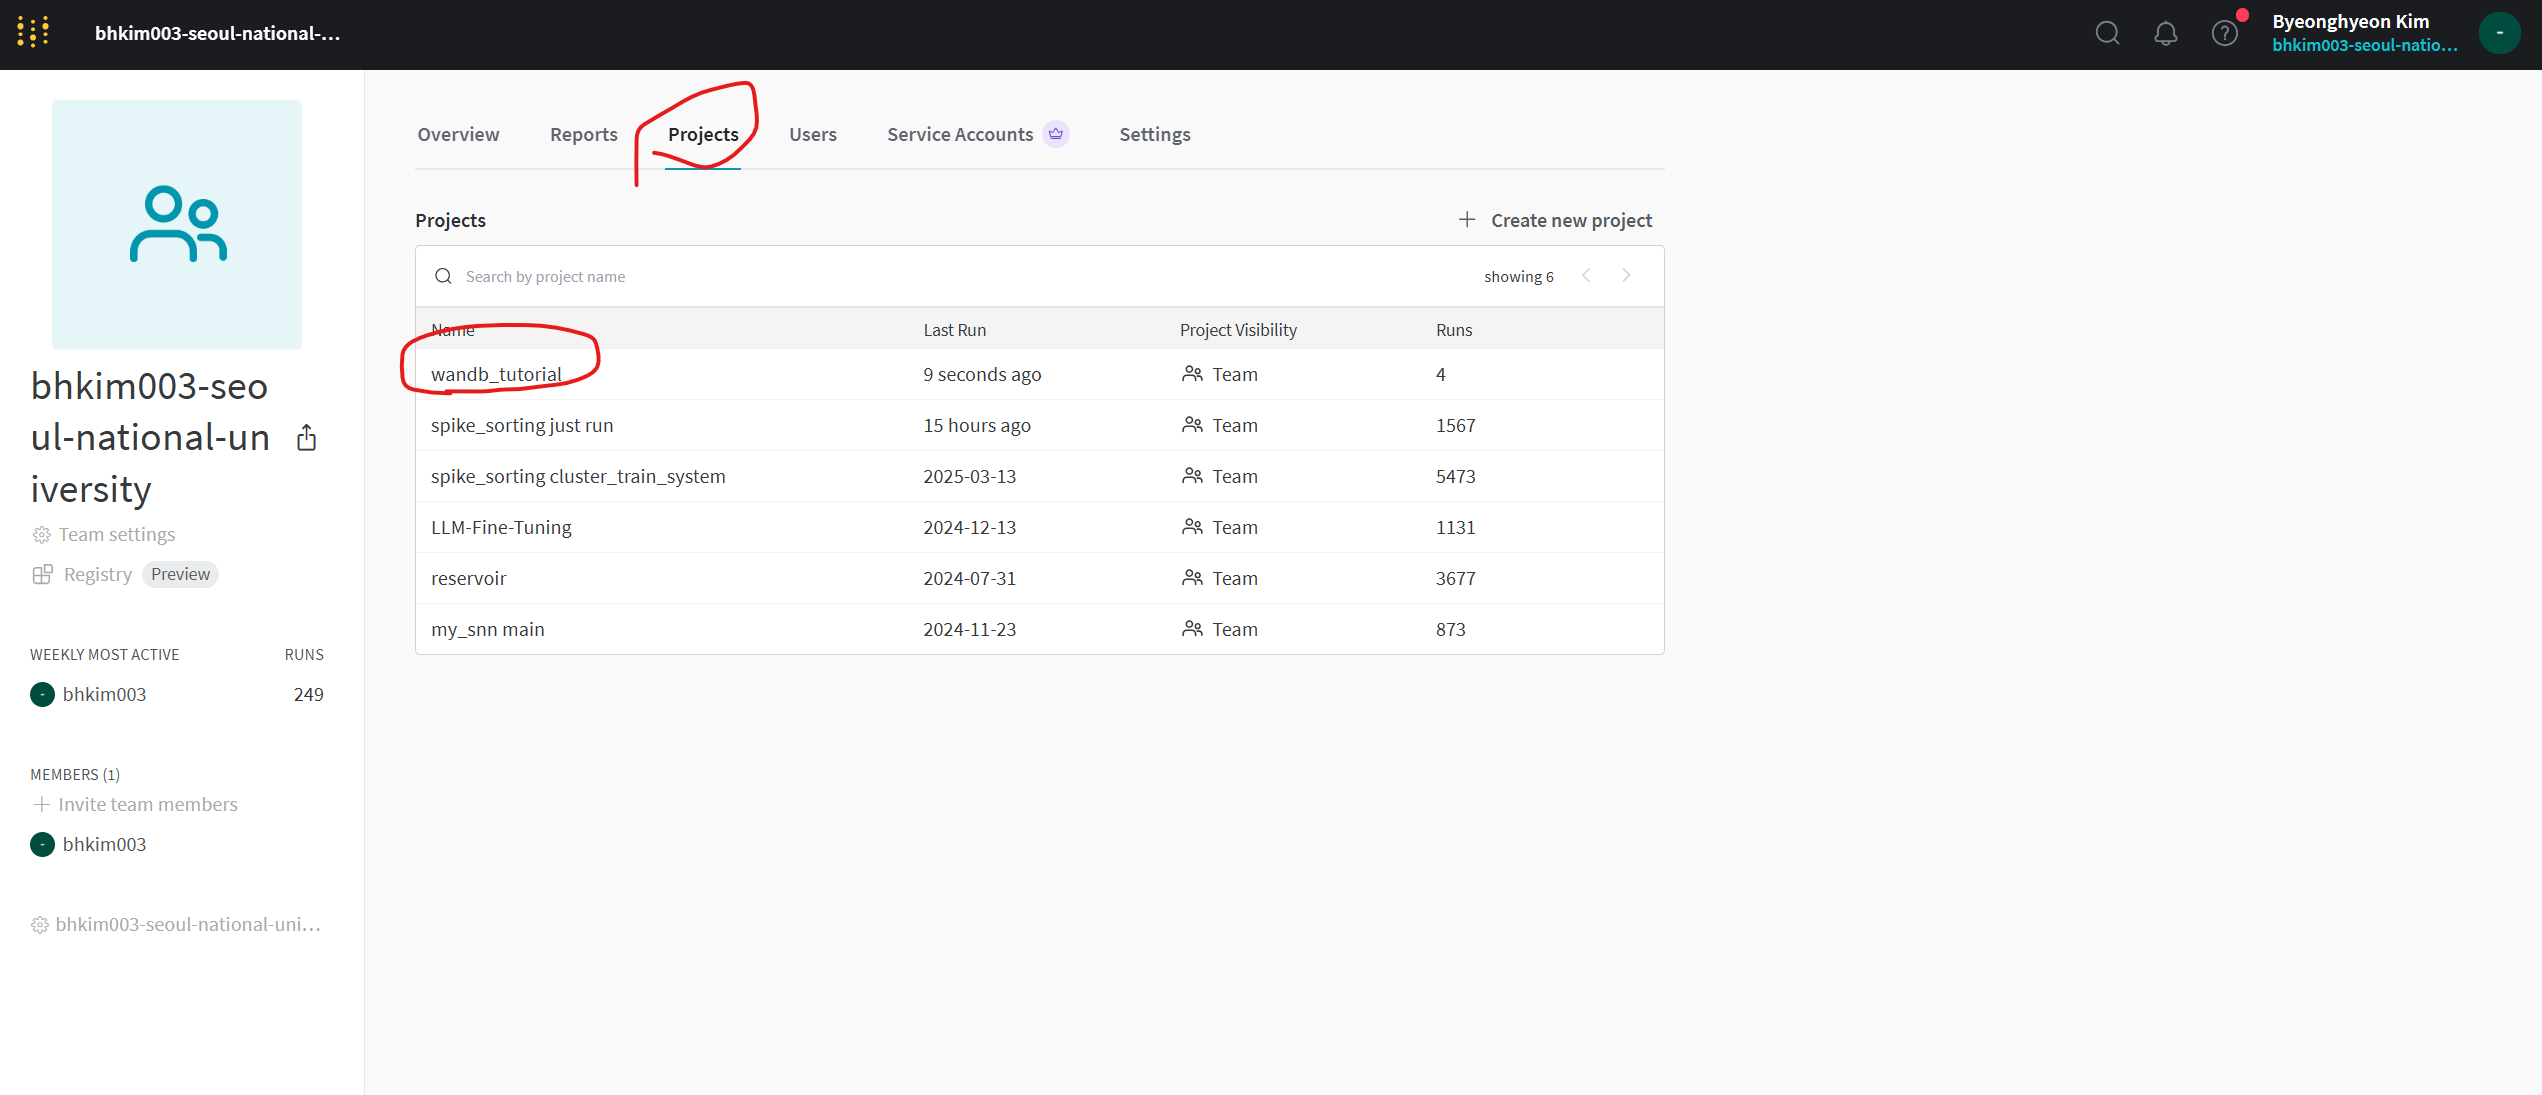

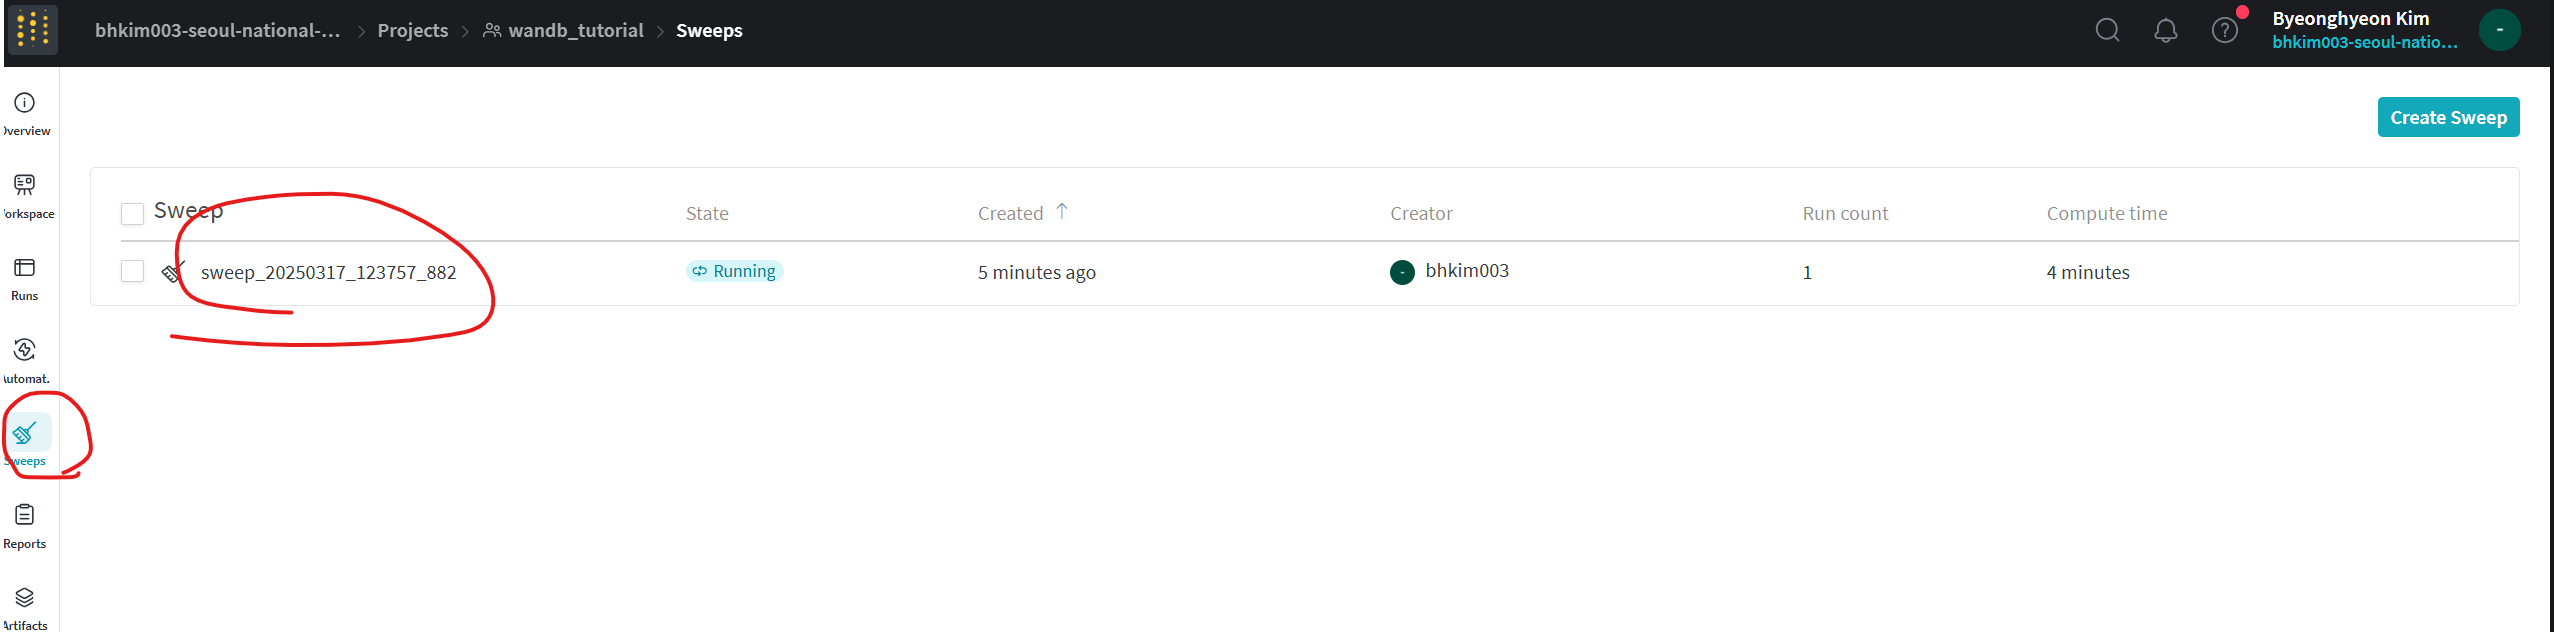

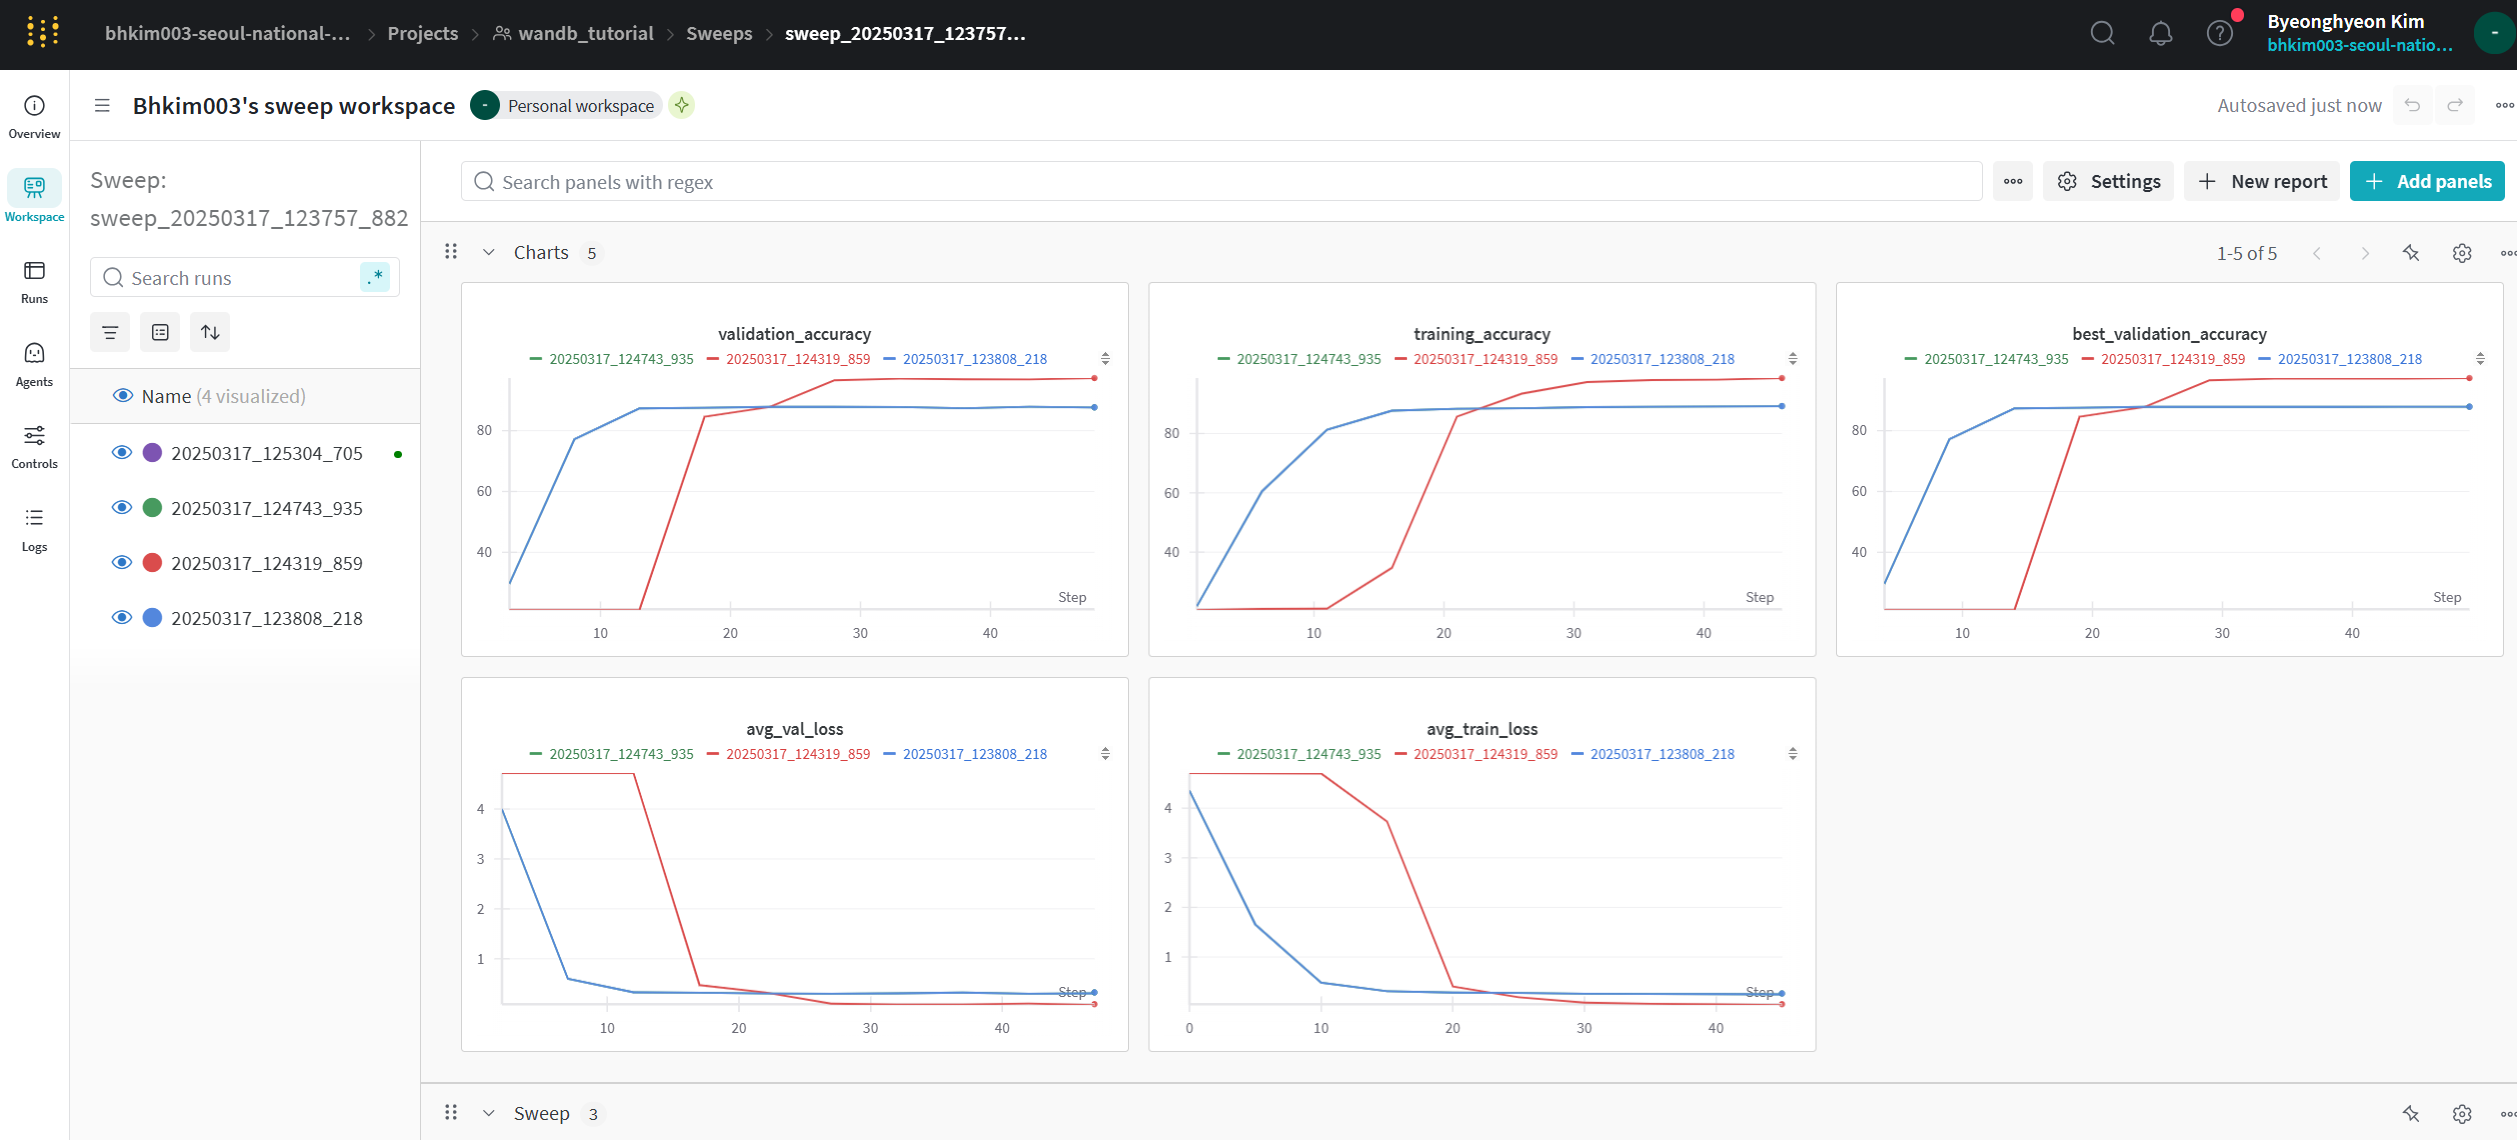

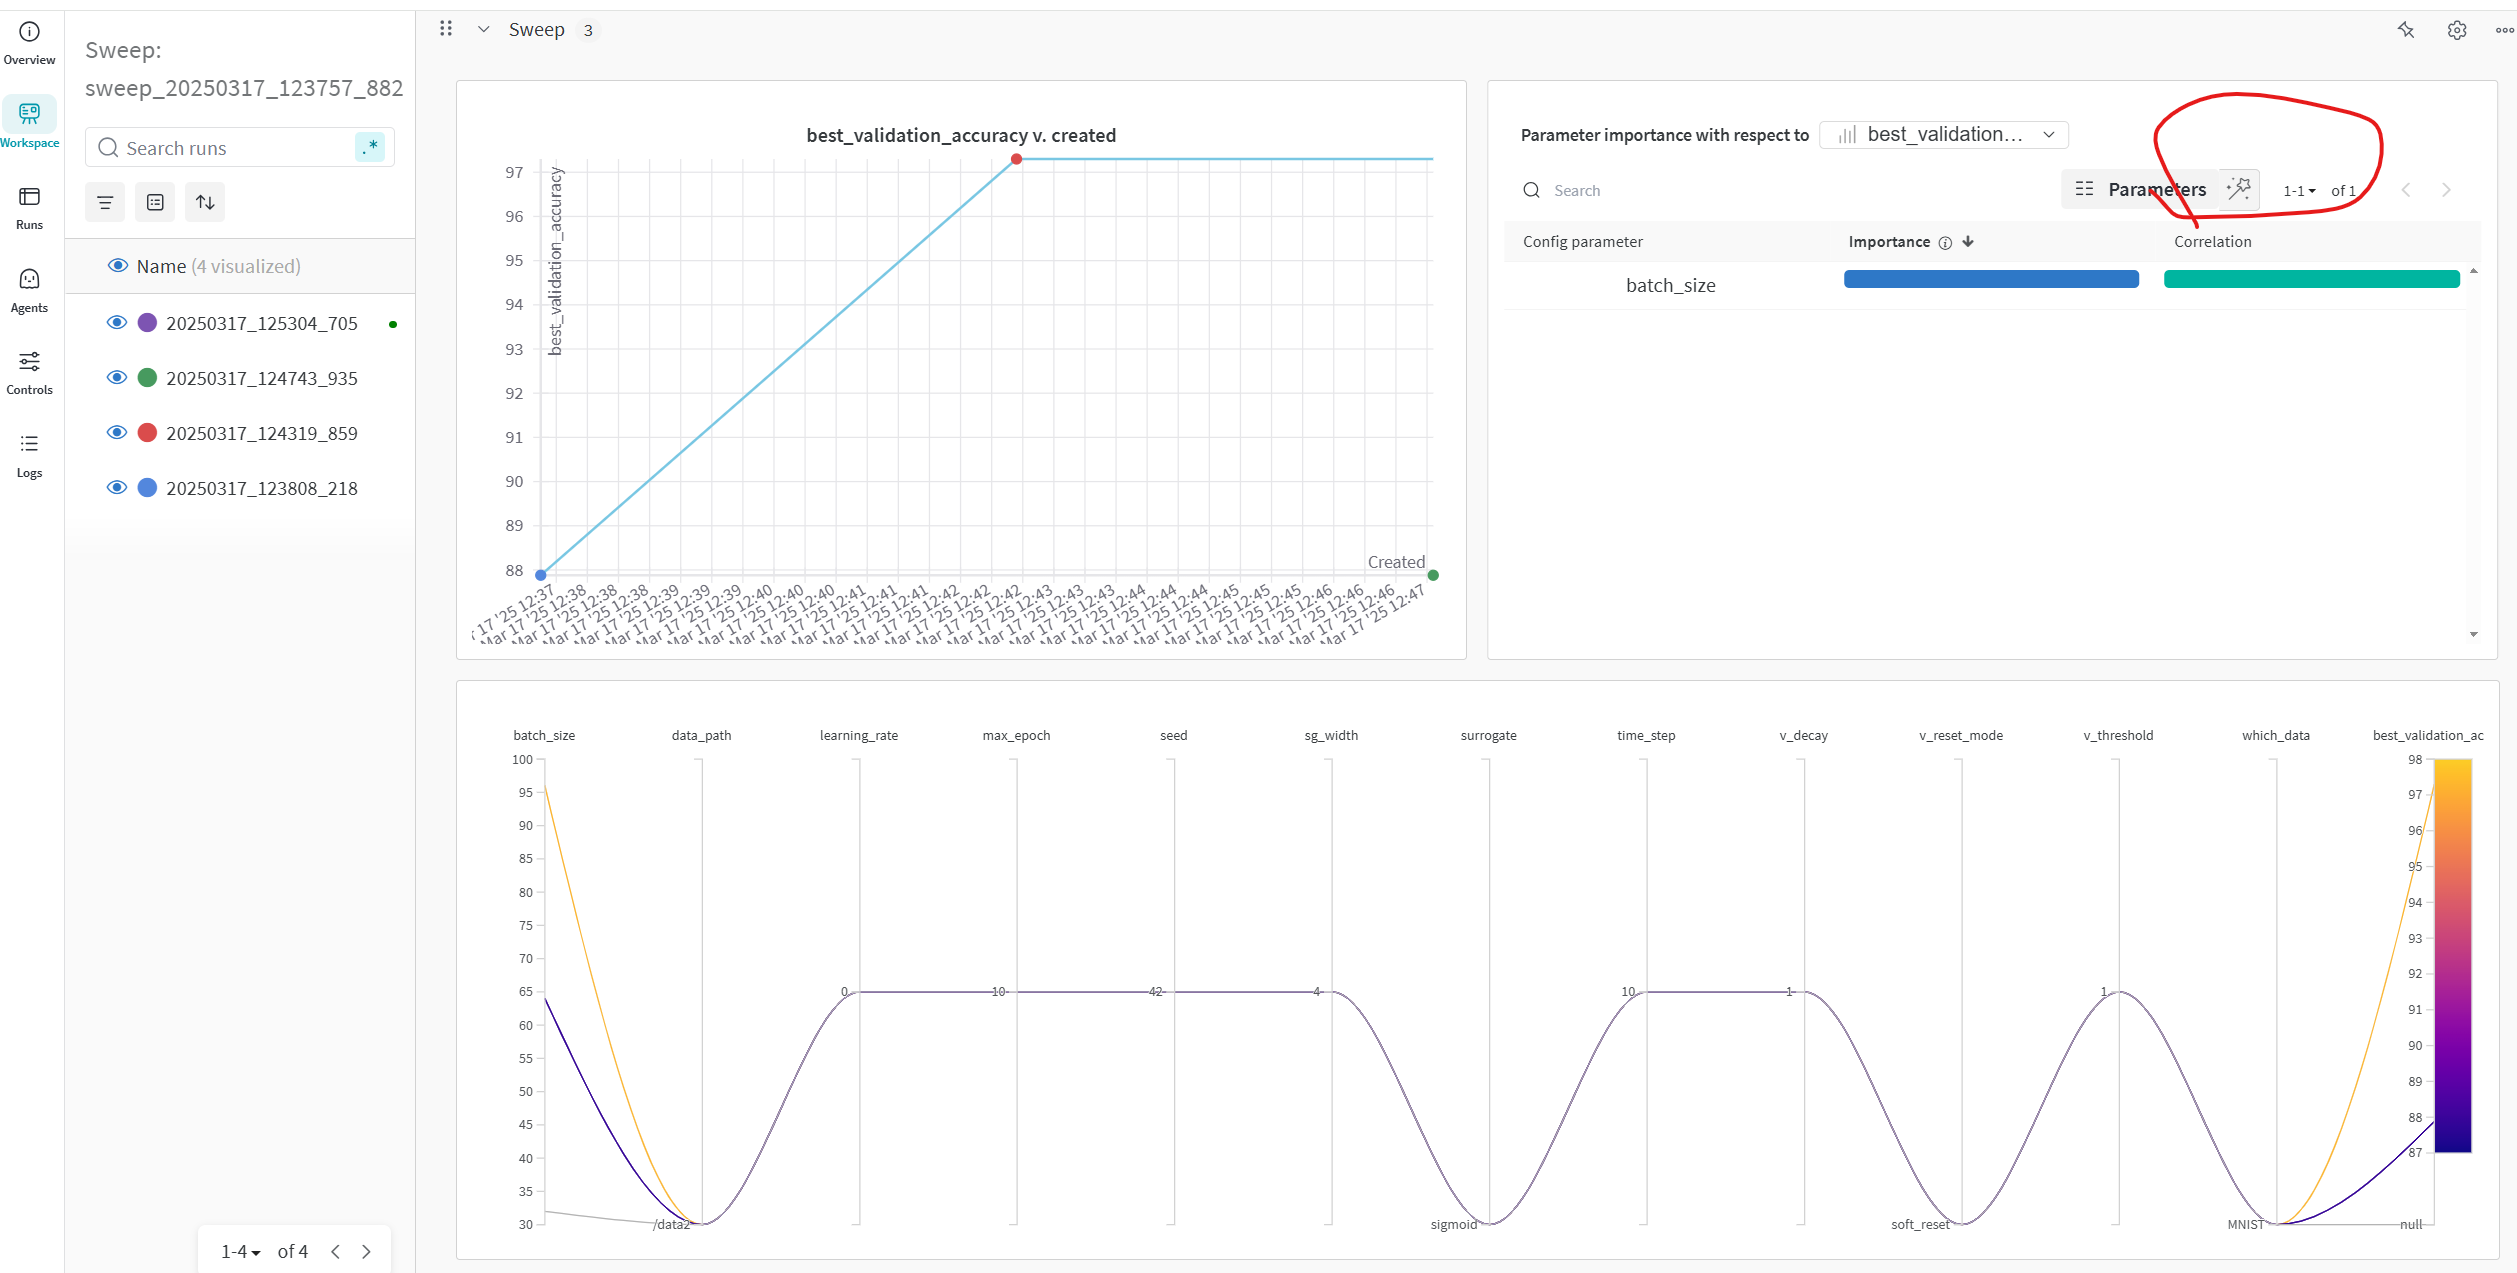

## 위 사진에서 마법봉을 클릭하면 스윕한 파라미터의 accuracy 영향을 분석할 수 있다.